In [225]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine
import random

In [281]:
books = pd.read_csv('BX-CSV-Dump/BX-Books.csv', sep=';', error_bad_lines = False, encoding='latin-1')
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'Publisher', 'Year-Of-Publication'], axis=1, inplace=True)
ratings = pd.read_csv('BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', error_bad_lines = False, encoding='latin-1')
users = pd.read_csv('BX-CSV-Dump/BX-Users.csv', sep=';', error_bad_lines = False, encoding='latin-1')
users.drop(['Location'], axis = 1, inplace=True)

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


Clean up data; do we have ratings for books that are not in the book data? Which rating system will we use (implict, explict)? Are there Nans?

In [282]:
def compactBooks(book, ratings):
    #count entries with same name and same author
    bookgroups = book.groupby(["Book-Title", "Book-Author"])

    booksort = bookgroups.size().sort_values(ascending=False)
    for i, ind in enumerate(booksort.index):
        #look only at the ones with counts > 1
        if booksort.values[i] == 1:
            continue
        else:
            thisgroup = bookgroups.groups[ind[0], ind[1]]
            firstind = thisgroup[0]
            firstisbn = book['ISBN'][firstind]  #get isbn for book with this index
            print(firstisbn)
            #loop through others in groups
            for i in thisgroup[1:]:
                #change isbns in *ratings* of group to firstisbn
                copyisbn = book['ISBN'][i]
                ratingsOnCopy = np.where(ratings['ISBN']==copyisbn)
                ratings['ISBN'][ratingsOnCopy[0]] = firstisbn
                
                #drop row of book copy
                book.drop([i], inplace=True)
                
    return book, ratings
            

In [325]:
def cleanRatings(allratings, books):
    ratings_allbooks = allratings[allratings['ISBN'].isin(books['ISBN'])]
    ratings_implicit = ratings_allbooks[ratings_allbooks["Book-Rating"] == 0]
    ratings_explicit = ratings_allbooks[ratings_allbooks["Book-Rating"] != 0]
    
    ratings_implicit.drop_duplicates(subset=['ISBN', 'User-ID'], inplace=True)
    ratings_explicit.drop_duplicates(subset=['ISBN', 'User-ID'], inplace=True)
    
    ratings_implicit["Book-Rating"] = np.ones(len(ratings_implicit['Book-Rating']))
    
    return ratings_implicit, ratings_explicit

Make the dataset smaller, we don't need users that have rated few books or books with few ratings

Take only the books with more than 50 ratings and only the users who have rated at least 100 books

In [284]:
def reduceRates(rates, userLimit, bookLimit):
    count_users = rates['User-ID'].value_counts()
    count_books= rates['ISBN'].value_counts()
    
    fig, ax = plt.subplots(1,2)
    ax[0].hist(count_users.values, bins = int(np.max(count_users.values)/100))
    ax[0].set_yscale('log')
    ax[0].set_xlim(0, 3000)
    ax[0].plot([userLimit, userLimit],[1, 60000], linestyle = 'dashed', color = 'red')
    ax[0].set_title('Ratings by Users')
    ax[0].set_xlabel('Ratings')
    ax[0].set_ylabel('Number of Users')

    ax[1].hist(count_books.values, bins = int(np.max(count_books.values)/50))
    ax[1].set_yscale('log')
    ax[1].set_xlim(0, 1000)
    ax[1].plot([bookLimit, bookLimit],[1, 60000], linestyle = 'dashed', color = 'red')
    ax[1].set_title('Ratings by Books')
    ax[1].set_xlabel('Ratings')
    ax[1].set_ylabel('Number of Books')
    
    rates = rates[rates['User-ID'].isin(count_users[count_users >=userLimit].index)]
    rates = rates[rates['ISBN'].isin(count_books[count_books >=bookLimit].index)]
    
    return rates

In [285]:
def makeMatrix(rates):
    rates = rates.pivot(index='User-ID', columns='ISBN', values='Book-Rating')
    rates = rates.where(pd.notnull(rates), 0)
    print('Matrix shape {}'.format(rates.shape))
    return rates

In [286]:
def findBooks(user_inds, ratings_matrix):
    books = np.zeros(ratings_matrix.iloc[0, :].values.shape)
    for ids in user_inds:
        user_vec = ratings_matrix.iloc[ids, :].values
        books = books + user_vec
    
    books = pd.Series(books)
    books = books.sort_values(ascending=False)
    top100 = books[:100]
    bookIds = []
    bookValues = []
    for i, ind in enumerate(top100.index):
        bookIds.append(ratings_matrix.columns[ind])
        bookValues.append(top100.values[i])
    return bookIds, bookValues

In [287]:
#find the mean rating for a given user, only looking at book which they've rated
def calcMean(user_loc, ratings_matrix):
    user_ratings = ratings_matrix.iloc[user_loc, :]
    #select only where rating != 0
    user_ratings = user_ratings[user_ratings != 0]
    
    mean = np.sum(user_ratings)/len(user_ratings)
    return mean

def findTitle(isbn):
    p = books.set_index('ISBN').index.get_loc(isbn)
    return books['Book-Title'][p]

In [288]:
#predict rating for a specific item/user
def predict_rating_explicit(user_loc, item_loc, sim_user_ind, sims, matrix):
    mean_rating_user = calcMean(user_loc, matrix)
    sim_sum = np.sum(sims)
    rate_sum = 0
    #loop through similar users
    for i, sim_user in enumerate(sim_user_ind):        
        product = matrix.iloc[sim_user, item_loc]*sims[i]
        rate_sum=rate_sum+product

    prediction = (rate_sum/sim_sum)
    return prediction

#predict rating for a specific item/user
def predict_rating_implicit(user_loc, item_loc, sim_user_ind, sims, bookvalue, matrix):
    mean_rating_user = calcMean(user_loc, matrix)
    sim_sum = np.sum(sims)
    rate_sum = 0
    #loop through similar users
    for i, sim_user in enumerate(sim_user_ind):        
        product= matrix.iloc[sim_user, item_loc]*sims[i]  #weight rating by similarity
        rate_sum=rate_sum+product

    prediction = (rate_sum/sim_sum)
    return prediction

In [289]:
#find the most likely to be read over all books
def recommendbook(user_id, ratings_matrix, rateType):
    if rateType != 'imp' and rateType != 'exp':
        print('Unknown rating type!')
        return
        
    knn_model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
    knn_model.fit(ratings_matrix)
    
    user_loc = ratings_matrix.index.get_loc(user_id)
    user_vec = ratings_matrix.iloc[user_loc, :].values.reshape(1, -1)
    
    #find similar users
    dist, indices = knn_model.kneighbors(user_vec, n_neighbors= 10)
    
    #ignore the first item, it is the original user
    sims = 1-dist.flatten()[1:] #most similar is closest to 1
    sim_user_ind = indices.flatten()[1:]
    print(sims)
    
    #list books similar users have read
    simUserBooks, bookValues = findBooks(sim_user_ind, ratings_matrix)
    
    predictions = []
    for i, book in enumerate(simUserBooks):
        item_loc = ratings_matrix.columns.get_loc(book)
        if (ratings_matrix.iloc[user_loc, item_loc] == 0):
            if rateType == 'imp':
                predictions.append((predict_rating_implicit(user_loc, item_loc, sim_user_ind, sims, bookValues[i], ratings_matrix), book))
            else:  
                predictions.append((predict_rating_explicit(user_loc, item_loc, sim_user_ind, sims, ratings_matrix), book))
        else:
            predictions.append((-1, book)) #already read
    
    predictions = pd.Series(predictions)
    predictions = predictions.sort_values(ascending=False)
    recommend = predictions[:10]

    for i, (rate, book) in enumerate(recommend):
        bookTitle = findTitle(book)
        print("{} {} (expected rating {:0.2f})".format(i+1, bookTitle, rate))
        
    return recommend

## Time to put the recommender to use!

In [290]:
books, ratings= compactBooks(books, ratings)

0861782356


/Users/jneilcottle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0553211412
0835902242
055321215X
0451518845
0689839618
156619301X
0812505018
0440403553
0451523067
0439409292
0451187903
0451511328
014034294X
0312148267
0451157443
0762414197
0440224675
0517618141
0140449124
0451526341
0451177096
0553211714
0425080021
0395489326
0451521358
0671461494
8878242357
0451521897
0451162072
0451210840
0671722727
0618002235
0451524934
3257208626
0425049981
0451526562
0451523504
0451139739
0553258001
0451191137
1556701616
0451525949
0345272579
0064406601
0451525221
067172262X
0441294677
0618129111
0451163524
0440206154
0452280621
0553211374
0553208845
0446310786
B00009APKU
1853260991
0140042598
0785789073
0671722816
0140317937
0425098400
0743211383
0451519574
0451625889
2764104936
0030554381
0425104273
0805420460
0440471869
0451628039
0399141146
0380977788
0451519078
0618002227
042511774X
0452254345
0671704664
0802133347
1569310203
0441068804
0440235596
0590988867
0451173317
0743206045
0553122509
0451203046
0451153553
1559029838
0380731851
0451520955
014032724X

0440363586
0451521161
0679407715
0446530077
0515128600
0375707212
0440217563
0525405224
0425062856
0060269944
0671680781
0590404709
0449142760
0590112899
0451202341
0679732764
2253056871
0380015188
0440343690
038081479X
0385490992
0385333641
0515116068
0553103679
0440215781
0446350419
0440214432
0140067779
0345331354
0525947647
0451519728
0679402470
0441142672
1573226122
0425094545
0441359175
0451620569
0425054721
0425141551
0425182908
0553278819
0449911462
0060090375
1853260363
0375703055
0446357405
0451133935
0345334302
0330376136
2253022918
0394542150
039470293X
0316154067
0446613053
0140086994
0440201101
0061008109
0425181111
0843938447
0440404908
031231616X
847600060X
843391426X
0382243579
0525943862
0070212570
0515087254
0880299053
059043893X
0425101452
0449208133
042510107X
055357602X
1551664348
0425042715
0553012665
0688059457
0451183762
9500284855
0515130966
0312962339
0156001942
0743482891
0804902097
0064406865
0425048578
0140430318
0450411435
0446606383
0671524097
0553278355

0425143538
034538184X
0553407945
0140243372
0060987324
0671032658
0140350748
0061062863
038070840X
0452278902
0060168013
3442309026
0808572407
0425163148
0441078990
044991089X
0440222028
0440409233
006019197X
0064473619
0399142053
0671028383
0140008217
0345314247
0349111863
1573222267
0425155404
0553053701
0064408329
0375714588
1591161142
1862300887
0061003689
0743203399
0312924585
0425026647
0316602051
0449704033
3458345604
0688025072
0553264478
0312989385
0553572210
0449220184
067178546X
0399144897
0553354779
3453088433
0312922620
0316952664
0425184943
0152012656
0380726815
0449214362
0340821191
0446364827
1555217575
0786814179
061810450X
0671036688
0609608533
044022036X
014017530X
0140340203
0399133550
0553377892
0345353617
0140042393
0553802526
0446613193
0425149625
0754002616
0553287397
0399147020
0553250523
0399142983
0743444965
0553076787
0060195932
0312924801
0425185508
0345396812
0765342472
0804901112
0452281296
0140255893
0553561669
0312902026
0425136191
0395907284
057116272X

0399142851
0671438565
0140243518
034532580X
0445405848
0446312193
0399145664
0374232105
0380703130
0156010887
0515041858
044106857X
0385278861
0441469299
0590413740
0425064573
0140240187
0684801051
0312244916
0465005594
0060508183
0380725576
0413593509
0393001644
0449214265
0441009328
0345430514
0441795773
0515071056
0671447807
0452254264
0060198125
0689848048
0451204530
0380778556
0345370805
0061090565
0671894412
038000917X
3453160797
0451523822
0446607274
3499230755
0440164842
0385335377
0671674366
0449239888
0671568841
B00007MF56
0671556835
0440111811
0060976772
0345320379
0688065317
0385134681
0140169598
0061014176
0586062009
0385333560
0812550927
8477201447
0316769509
039309426X
0385475721
0515125040
0385244673
0061096024
0060084022
0312975856
0842345566
039913932X
0060977477
0670843342
0613325419
0330023063
0440213673
0140325654
080410591X
0425035689
0385091907
0446613886
0553275720
0385282281
0764222295
8466302360
0060934980
0091769388
0440504716
0671463195
0805208119
0804103801

1582340099
0006550576
0195029151
0713996048
0345439732
0684822768
0786883219
075820230X
0441011020
0743464834
1569472564
0446359688
0684832836
1558585362
0553580337
0892964723
1857022432
0575602139
0802713661
0060179570
014062225X
1563892278
0449908453
0441818145
1585420301
0671877739
0816013551
1560250801
0899681069
0446343099
0385482329
0006548830
0804102112
0395908728
0345381645
0747565333
1582341494
0771042175
044022165X
0449213730
0061000809
0679452397
0441008291
0823023753
0441007201
0151739269
0451522389
1573229318
0345377494
0451133137
037540340X
0451212177
0345359941
0671511475
0345301072
0874778794
0440400422
0441083951
0812566777
0515073873
0451205448
0670856045
0812535065
030681045X
1559724773
002542730X
0671737899
0937958263
0449213005
2080720201
0136952062
1551664917
0061010952
0441812546
006272018X
0553580272
0671637525
014131141X
0446364460
0816047022
0553171712
0061050261
042512343X
0385484917
0399526005
0679720561
0345394259
0671867156
0553233114
0380786583
006109174X

0679423346
0385121687
0446518506
0385312121
0300074298
0440916127
0843941936
0375814116
0679454314
0312971230
0385042671
0385501587
3423123281
0812502671
0340707925
0446601985
0385310366
1567311806
0061096180
0755108272
8435060330
0553569473
0553286587
0871358816
0061052043
014027927X
0374173710
031242115X
0312864108
0812530225
0688168957
0451205782
159105236X
0736628916
0749394803
0060981075
0312327641
0425172643
0553291165
0553123718
0380711621
0156028751
0441000150
0449206238
0515095400
0306809893
0439049962
0385729332
0553283111
0061020397
0061082392
0553236865
067084022X
0385333498
0330308769
0233986227
038549792X
0890818169
0763611999
0140349111
887641486X
0848711521
0312850883
0749310634
0671834606
0671744283
0816720223
0345288475
0306813270
0345334310
0330320459
0688044816
349204204X
0553287567
0060962763
0890876797
0393324141
1560250909
0449200396
0446353728
0142002968
0451211561
0743486943
0226264211
051722285X
0449911659
0786804440
0345406036
0451190327
0880015829
089296474x

2290319155
081297106X
0425085295
0786014873
0140159797
0451114078
0723205981
0060913312
0571139493
0723206007
1569870640
0452279755
0670030201
0156013126
0805055045
0394735307
0155758314
0345357108
0449211037
0931580439
0446358584
0451184785
0449203719
0061008338
0553801589
0963434845
078943413X
0674748891
0446356832
0380570009
0881846090
0590405357
0517599058
0399137149
0805055614
0449221121
0805068317
0452279690
2070362388
087923556X
0671646060
344244991X
0738200654
006441034X
1551664976
039447144X
0060002093
0312862709
0786890444
0060953675
0452281385
0441790992
0440984459
0440401380
0446515671
0451451732
0671462873
0786803398
1559942010
0330376144
0671014196
0330330373
0380977664
0152380205
0140314202
0843946083
0440216877
067100378X
0671708252
0451454677
1573754226
0446300888
0786867930
0441005926
8466304630
0140371494
0890432848
0399140158
0689851863
0812550188
0441009832
0380762773
0394509722
0609804138
0743446445
0525483802
0380726920
0394530101
0142003557
0670815144
039453090X

044920703X
0553299646
0385479824
0446610615
042508034X
044144525X
038549503X
0884481921
0349111030
0394563131
0880707232
0449701778
014070728X
1880985497
0140042407
0688087523
0882643266
0060910992
0441444881
0446677698
0590415883
0670882089
000225669x
0380708744
0440224713
0060926058
0451628314
0385308361
3442415578
0786005467
0060936266
0345323211
158234082X
0316482110
044023655X
0821726994
0316561185
0451523660
1850892237
0744523605
044050421X
0553582755
0385276338
0688174590
0786883618
0060508205
0590379461
0671468073
0399138242
0062735241
0765304767
0312109733
068483149x
0451158261
9500419335
0553284347
0671823337
0060976152
0446351709
0553236954
0441010571
0446343455
0892961627
2253154202
1573225770
0451155068
039475929X
0091882087
0553149121
0553472321
0609810022
0613557727
0449006832
0330020706
059022297X
0061030651
2070368017
0060187026
0399144714
0060197870
0515108944
1551520621
0445407808
080211508X
0345433785
0671689487
0446606456
0060245018
0679435360
2013218923
0670875910

067103619X
0380786702
0142000930
0061097241
0060954884
0425038823
1556114249
039332303X
1551665190
0395393876
0385319037
0553276735
0836279859
1556522746
0440164125
0848705246
0060921145
0312182015
0140117563
0805052151
0553231979
1575666804
0517701405
087584801X
0375410538
0140266771
0380709066
0743458214
0451524497
0446610933
0618154051
0395653681
0061013617
082175159X
0821772333
0312930712
1575664666
0425121828
0688102719
0590440861
0440213282
031230711X
0553802674
0451174968
0688170315
0446306193
0140104801
0939165279
0821743198
0446353507
0385497296
2290314900
0060159685
0873955730
0446531286
0670821616
0385474946
039914739X
3442350298
0312962843
042519549X
075284332X
0525940669
0743422937
0441374719
1570427003
1400047862
0425093336
0440457556
3423241489
0140174397
044900273X
0375502238
0385297548
0716604868
052594186X
0451166647
0345443233
006080985X
0380706636
006103004X
0375410945
0515075051
0451162188
0394552377
1573220841
0140280529
0943403006
0747549370
0140376283
0446609544

0064407683
0441885691
067103605X
0763625566
039592474X
0393049272
0312979665
0140280189
0934081174
0140083871
0380785595
0805060367
0807612642
0670800139
1840460962
0385316151
0812555481
1840460040
0749706201
067076292X
038518896X
0394549406
1840460571
3821808187
0006490603
0805006559
0804108773
0425158985
0395500818
0062507540
0747553734
0140367098
1564029654
0575071117
0449906337
0688114490
0821765213
0446606227
0451411153
0025607006
0698115813
0312863691
0140259112
0679833692
0425143570
0140179208
0380704161
0670710946
0812575482
0295972254
0486247791
0671004573
0446517178
0140165347
0060173025
0525946764
0312876874
0812522370
1551664836
0385498799
0812520793
0312968302
0152413588
0399127267
031220972X
0822371510
1551660393
1573441252
1574534149
0451406249
0140157654
0425190668
0688103847
0061043664
1551666383
0689849176
0553561642
1551662809
0679802134
034544227X
0030621984
0061013714
0553104039
0812500504
0060192704
8432203777
0345421027
0451175824
1570361983
0380775123
0771079400

0373835396
0440224748
0060152028
0345301706
0451451481
0553576399
0312168446
0345450728
0515087629
0345463404
0670032034
1562820680
0060938374
0425185303
0061057754
0679767819
0449912582
0393319288
038550117X
0345409469
1885983395
0440119383
0449905950
0451524640
080213825X
0060666838
0345308999
0061015075
0345339967
0345336283
0345309006
0006384854
0061056391
0679727124
014044629X
0553297422
0451210700
9875500046
0375405445
084394224X
0345310799
0449223833
0451148029
0425086836
1562823779
0380701731
3423204206
0140296409
0802710581
0743241754
0812571088
0804002800
0399141375
0380789000
0425097471
0345315693
0345370066
0676973787
0061052345
0070539650
0345447522
0688166180
0671042491
0553378643
0525945822
0688171567
1853268461
0380599236
0749314206
0399146504
0399148663
0436203316
051513175X
0743242548
067003195X
0525440445
0688164412
0441009050
0765300435
0394800389
0061010650
0739307320
038550926X
0525936327
0140263640
0698119177
039458340X
0684194201
0140345353
0805241396
0771029233

0312276966
075820180X
0525936831
0375501207
0671669516
0609603825
1573228575
0743456831
0889223017
0765301075
0671218972
0446520713
1578562775
0373970382
0449219283
0060808241
0312890451
0446517860
1573229415
0385495757
0340682272
0553580531
0688159141
0451185994
0743454146
0717283437
0515123838
0758200978
0453031668
0770422098
0140255389
0749748028
0812500865
0156011433
015600254X
0156011409
0553206516
0879515082
0452283906
0553052802
0553155601
344223686X
0380708566
0553562614
0446356956
1560238755
0312855435
3442726735
0312875592
8433906909
0312853912
0520204956
0751526568
0743444329
074343059X
0446531588
0825302099
0812540220
0743442318
3453131150
0671645854
3596150531
0375708561
0316290998
0553282093
3822505455
0374158517
038081658X
0345305930
0380977613
044023607X
0553251139
0843941952
0374528837
0316912581
0439063361
3492049885
0898796814
0156329301
037550298X
0140383948
0374158150
0671039407
3442727952
0515132497
3453082435
0312315856
3498068768
0345463153
0394569962
0446612510

0679804196
3492256597
1569471169
0425176045
0312040598
0849942365
0440202116
0767903579
0201614774
0525942688
0679736875
0812514025
0671039873
3548600808
0375502505
0060248025
0446690155
0330335065
0060522259
0060522275
0679836101
0380803240
0821748904
8440685548
0451458206
0764227238
0312873085
0099356503
0306808048
0310218039
0515114049
0671034286
0425070093
0679889574
0843940166
0670874558
0394830148
0394873416
0394873408
0312967004
0385488947
0345404319
0345388623
0618124934
0618246967
0761509909
0515115630
8432068020
0446604089
843970240X
0446358657
3442541077
0413526402
0440124344
082175842X
0609809547
0060230398
0805003002
0425176797
8432215007
0395877326
0156027941
1583940162
8495501015
081956270X
0871132516
0449240339
0525946594
1860465048
0060393025
0152253203
0771081073
074350769X
0671026798
0375503587
0395752906
0395875145
0679411089
0395926882
3548600026
074343756X
0618155686
0618118810
0451199685
0385468547
0441226949
0385318782
0451190009
1582430772
006017496X
044100315X

0525945318
044018293X
158089061X
0312302487
0553579134
0140077235
0312775199
0446353205
055358457X
0446671002
0749005432
0385194099
0394574206
031298376X
0749318368
0345396529
0195092287
044922323X
0060507403
0399134190
0394582691
0806523409
0380585863
1570425221
0425128458
0515127221
0452283868
0140157115
0446341339
0395654890
3442442508
0743406273
0765340151
000639194X
1892065401
0871134799
0867209437
096788330x
0451409485
0062502891
0446521876
0553112600
0425157539
0345397800
042516828X
0345391187
0679422102
014032609X
0756402093
0553066684
0451163842
3453196155
0749744812
0060193328
0312145314
0380682966
0449005895
0312774842
0380732289
0894807544
0380785420
0425138739
0142004170
0452281229
0451191390
0446364622
087923833X
1570719713
0679415610
0380808072
0393306135
0393313425
0449128288
0440215633
0441008593
0140237895
0446532231
0345461754
3492221521
0330248308
0140241434
0821714317
0684864398
8426401007
0933149492
0060937114
0394588207
0525938532
044651862X
0515100307
0553154796

0743437640
0062513362
0671578197
0963596772
0843925957
0385336306
1562829300
0385299087
0679767959
0553287796
0345319532
1564781674
0821744526
0345326210
0590418262
0440159466
0679740759
0517580101
0689849346
0064470229
0446354775
0451201183
068931762X
0451171195
0380619458
0451176820
0140280103
0370014804
0451452828
0316367893
0395597048
0451196856
0345428927
0140139974
006093025X
0192833731
0451516680
034530084X
0060191805
0441008216
0375755195
0446608912
0440175526
0140046704
0064471837
0380726297
034546608X
006017949X
0345345975
0061093580
0446300004
0805003614
0807821209
014043092X
082173833X
0142000604
0785748830
0679772596
155583180X
0688121381
2070393437
1883052289
0880014989
0671600745
2070334430
0713993634
0312981600
0820323020
0609810111
0553576356
0812509560
0758202059
0553353268
0690047304
0843950773
0061032123
0449215024
0399149635
031227470X
0312979444
0812551702
055309677X
051513239X
0307602079
0445408863
0060972122
0743436210
0312275374
081183199X
0553572261
0140109064

0060975229
1559944277
0553573225
0373970323
0156000520
0060190094
1573225797
0380800160
034081800x
0060186267
0804104549
0671732943
0525936084
0140156291
0380451875
0553572245
039304971X
044651781X
0060555653
0451193261
0451209540
0446309621
0312855184
0440136482
0140039236
3596152976
055357549X
0590416499
039332267X
8429446265
0062585274
0385721404
0060915439
0060506067
0815410255
0743238532
0553284169
0881844365
0380811413
0440224985
0778320197
0440207509
0671742868
0140063315
0030418461
1568650450
0385418868
0394559487
0380976633
0446607851
0451198425
0060917016
0064408191
0449214931
1585670081
0060936177
0207153671
0670867675
0140309276
0816014000
0441001971
1860466834
0679437630
0006148891
055326981X
0312139853
0395349222
1568652895
0385319800
0679455884
014043223X
0446323861
0441107060
0553090828
0061090417
0312904878
0449207269
0764222112
0553257048
030710446X
0380814811
0812567080
0595121209
0812535928
0446361275
157673613X
0688169708
0140017917
0671887971
0425154734
0345370139

0425154106
1893956342
0399146008
0452263018
0394551427
0679751319
0843926074
0156008351
039441392X
0802115705
0345917421
0425177793
0452278821
0440207835
0812575393
0312278225
0425118711
1562477528
0892963891
0553283316
015140934X
1569471894
0836261291
0553062182
0688021174
0758200390
0396065023
0399147357
0812540018
0330358561
0812568680
0679438793
1551666839
0060514949
0446529001
0385170556
0140144994
0684867583
0385292244
0374171386
0871133962
0345446542
0767914848
0671721720
0307301281
1555842356
0821772236
0553582453
0449149064
0932857108
0156013908
0061010014
0446521582
0671042742
0552999458
0446609560
0316852570
0452259592
0881848808
0786703873
0312022808
0064471063
038523015X
0451450167
0880298456
0671034693
0553584383
0345421280
0446607339
0805066411
0671009257
0670889490
0553575635
0375703373
0812523849
0441008933
0062506595
0061009504
0007135688
1573225320
0679448667
0380976463
0060913304
0840776381
0440130913
0689806477
0356232700
0452263069
0553243063
0312853173
1585421375

0517706814
0553225871
155704256X
0804118876
0374184232
0345388186
0449912345
0312155654
0028622170
0553263587
0671441841
0553073958
1563898586
0553259334
189205101X
1903468000
0515134449
0820315567
0060954930
0316735671
1573220779
0316781266
0312181213
0449911926
0743417216
0425076571
0316082511
0553565214
0140351116
055325233X
0449905616
0451408896
0140157409
157765692X
039458872X
1892738341
0679428453
0345440757
0440215013
055358068X
0671531522
0671417118
0312041454
0553227734
0446611816
0425168298
0820321451
0789457105
0679758380
0060177330
0945353871
006251072X
0446609951
0060512385
0380000881
1564580741
1564581764
0743435257
0140059628
0670860212
0679454756
0345311698
0345450264
0684835525
0767900561
0689821654
0345303091
1861591675
0671629689
0448477734
0451190157
067169054X
0671557106
0671733923
0449212963
055321232X
089375711X
8467004975
044912617X
0380817446
038072751X
0671563076
0345369793
0441007732
156931702X
0312980302
0679752854
3810505153
0786812524
0553340344
3492228224

0446829773
0345383389
0553141422
1573220434
014026759X
0440146291
0679412921
0064473783
038530000X
0345309049
0425138186
0812913248
0374213542
0449910415
0440161061
0399148582
0394562879
0064434729
0679767096
0786006587
0140094199
0525943730
0440198577
0374520763
0312853491
0394747232
0060959622
0452280192
0749933038
0920668364
0807083461
1565075331
0465067867
006621341X
0525675299
0967303516
0394487265
1582341516
0451172698
067081752X
0425157210
030710205X
0590403214
0679429301
014086637X
0525248781
0380779765
006039384X
0670831360
0883659948
0451179196
034543434X
0525935495
0679404465
0440205506
0679406018
0312861540
0064402223
0140286012
0517488906
0345390180
1841953814
0312872143
0316545562
0942494946
0440504961
0449203662
0345419049
0312283784
0440193613
0553261738
0345257502
0553235575
8481301507
0380775832
0521443172
0553284355
0375505601
0743435400
0312854099
031239019X
1573222127
0812519507
0773761551
0849909627
0316286850
0517701723
0812540379
0553281097
0523425570
0553569538

0786863013
0881844624
0471123005
0375701311
0553249371
0743254392
0395633133
0345346602
0590132814
1551665336
0571168639
0517554550
0316919896
0425042944
0394497503
0812523989
0892966882
0688174035
0451203593
0440101115
1566193060
0807014184
0821727559
1551664321
0671450727
0452272971
0345446984
0446350109
0345330153
0671427822
2738107915
0449242773
0449912787
0449127621
075350426X
0061002704
0671673688
0375401423
477001922X
2702478921
0425147711
0345443284
0375407340
1557733856
0395752868
0345334256
0553566040
0553210122
0345302737
0380795566
0786889535
0515098167
0061052493
0448124114
0345304314
0380791226
0345303067
1551664739
0061094757
0385721919
0140371915
0061054437
006100717X
1555610773
055321246X
0393034496
0440222877
0785275304
0345327217
0671015680
078670697X
002411510X
0446608149
0061073628
0915166100
037541181X
0440220270
0060012900
0380705737
0515136433
060980748X
0449221059
1889893544
0553249231
0393701484
0804108145
1555612326
0345315227
0679724257
0811821315
0670873683

0140073477
039526619x
0140235221
0517703246
0670803340
0312271301
0385260431
0345347552
0831761547
0394584554
0441009751
0452263301
0843945257
0312146884
0520228383
0866119655
0671602217
0671507028
0061008117
0394571932
034531221X
0671445774
067142212X
0684854805
0380872218
0553248847
0440221056
0440223210
156023184X
068816711X
0679448608
0385266367
0821758551
0028603516
067164159X
0453010164
0440409918
0030591724
0671691503
3442415934
1585420220
0553100831
0767905202
0871136104
0879519355
0517093650
0380727943
0449006883
0340717041
0893754897
0451137426
0877935459
0395259398
0375431640
3423084065
189020823X
0312915934
0671864866
0064408892
0156627809
0671318411
0688039626
0812503910
1566197155
0465029973
0590136712
0394520955
0060269456
0933256914
155858028X
006008118X
0062514377
0312962452
0425111857
0930289234
044652560X
1889330299
0380788152
087113733X
0743436180
0812520823
0152020802
0001046438
0752843370
0743524829
0525944834
0151157936
0140096825
0060171316
0345344464
0553097172

0743205650
0805033203
202009472x
0805051163
3442545137
0060933755
0375420967
0425141977
0671252259
9684068573
0374527075
0345384237
0553574116
0434046841
0440224071
8433920308
059045367X
3746651042
351839648X
0892967870
156458027X
0812522400
848969365X
3216305082
0394725484
8432064335
0440216575
0312952716
0930603044
0415289793
0812530195
0515093920
0786890126
0816032130
0060007192
1565920465
1575661918
0425098559
0451206428
055315916X
0743467221
0553114522
0425182169
3257232861
0743224612
0064405079
0440203856
3250101656
0525934855
1573225312
0385491247
0671463144
0913592021
0312708203
4770015437
0451202120
0099287927
038070322X
0060175699
0747401241
0690091184
0060571667
0786889314
0380816792
034541103X
0231118597
0192833634
0380731622
0843943866
3442424402
0316881562
0670589101
1558746218
3518382357
0553080237
2266091611
0786881348
1574410296
0195135156
3805207379
1562478494
0380978849
0517591928
0374190771
0060168579
0609601091
055322560X
1558533273
0515106070
8408042459
0380808323

In [326]:
bookgroups = ratings.groupby(["ISBN", "User-ID"])

booksort = bookgroups.size().sort_values(ascending=False)
print(booksort[:10])

ISBN        User-ID
0439409292  185233     12
1569310203  156111      6
0330332775  11676       5
1591161932  10354       5
0835902242  240258      5
0871359251  63714       4
1591822580  38023       4
            224904      4
037582345X  11676       4
1591822580  196160      4
dtype: int64


In [327]:
imp, exp = cleanRatings(ratings, books)

/Users/jneilcottle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jneilcottle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/jneilcottle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [328]:
bookgroups = imp.groupby(["ISBN", "User-ID"])

booksort = bookgroups.size().sort_values(ascending=False)
print(booksort[:100])

ISBN        User-ID
B0002K6K8O  179791     1
0394891333  230522     1
0394891899  198711     1
0394891767  124078     1
0394891732  238961     1
                      ..
0394896157  213350     1
0394896149  227447     1
0394896394  260865     1
0394896742  265115     1
0394895894  26284      1
Length: 100, dtype: int64


Populatarity based recommendations; what books have been read the most? 

In [330]:
ratings_pop = pd.DataFrame(imp.groupby(['ISBN'])['Book-Rating'].sum())
top10 = ratings_pop.sort_values('Book-Rating', ascending=False).head(10)
top10.merge(books, left_index=True, right_on = 'ISBN')

,Book-Rating,ISBN,Book-Title,Book-Author
26,1921.0,0971880107,Wild Animus,Rich Shapero
408,588.0,0316666343,The Lovely Bones: A Novel,Alice Sebold
541,431.0,0312278586,The Nanny Diaries: A Novel,Emma McLaughlin
166,418.0,0330332775,Bridget Jones's Diary,Helen Fielding
1105,415.0,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells
748,399.0,0385504209,The Da Vinci Code,Dan Brown
757,380.0,0151001006,Snow Falling on Cedars,David Guterson
356,367.0,0142001740,The Secret Life of Bees,Sue Monk Kidd
305,367.0,044023722X,A Painted House,John Grisham
118,357.0,0671027360,Angels &amp; Demons,Dan Brown


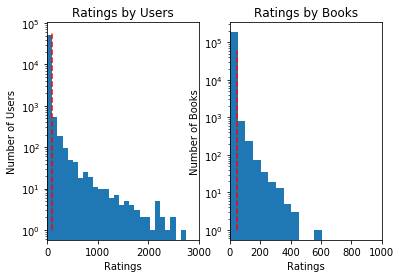

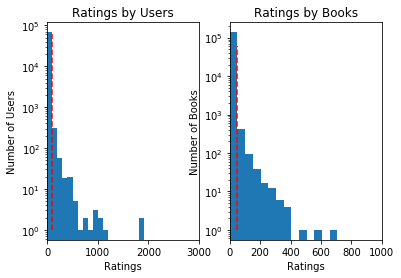

In [331]:
imp_small = reduceRates(imp, 100, 50)
exp_small = reduceRates(exp, 100, 50)

In [332]:
ratings_matrix_imp = makeMatrix(imp_small)
ratings_matrix_exp = makeMatrix(exp_small)

Matrix shape (1073, 1244)
Matrix shape (432, 626)


In [334]:
recs = recommendbook(11676, ratings_matrix_imp, 'imp')

[0.37822833 0.3762267  0.37345277 0.33790659 0.32993236 0.32954126
 0.31780318 0.30712638 0.30640545]
1 On the Road (Penguin 20th Century Classics) (expected rating 0.90)
2 Pretend You Don't See Her (expected rating 0.88)
3 Witch Alone: Thirteen Moons to Master Natural Magic (expected rating 0.80)
4 Turbulent Souls: : A Catholic Son's Return To His Jewish Family (expected rating 0.80)
5 Chicken Soup for the Writer's Soul : Stories to Open the Heart and Rekindle the Spirit of Writers (Chicken Soup for the Soul) (expected rating 0.79)
6 Before I Say Good-Bye (expected rating 0.79)
7 The Testament (expected rating 0.79)
8 October Sky: A Memoir (expected rating 0.79)
9 The Accidental Tourist (expected rating 0.79)
10 South Seas Myths and Legends (Myths and Legends Series) (expected rating 0.78)


In [335]:
#for a given user,
#remove 10 books, 
#then try to recommend books for that user
#then check to see if any/all of those books where ones that were removed
def testUser(user_id, ratings_matrix, rateType):
    user_loc = ratings_matrix.index.get_loc(user_id)
    user_vec = ratings_matrix.iloc[user_loc, :]
    
    #find where user_vec == 0; 
    ratedBooks = np.where(user_vec != 0)
    print(len(ratedBooks[0]))
    
    #pick 10 at random to turn into 0
    removed = np.random.choice(ratedBooks[0], 100, replace=False)
    new_matrix = ratings_matrix.copy()
    new_matrix.iloc[user_loc, removed] = 0
    
    #isbns of removed books
    removedBooks = user_vec.index[removed]
        
    #recommend books
    print('\nRecommended Books:')
    recommended = recommendbook(user_id, ratings_matrix, rateType)
    
    print('\nLooking for removed books:')
    
    for i, (rate, book) in enumerate(recommended):
        if book in removedBooks:
            print('yay! found book: {}'.format(findTitle(book)))
    

In [336]:
testUser(11676, ratings_matrix_imp, 'imp')

436

Recommended Books:
[0.37822833 0.3762267  0.37345277 0.33790659 0.32993236 0.32954126
 0.31780318 0.30712638 0.30640545]
1 On the Road (Penguin 20th Century Classics) (expected rating 0.90)
2 Pretend You Don't See Her (expected rating 0.88)
3 Witch Alone: Thirteen Moons to Master Natural Magic (expected rating 0.80)
4 Turbulent Souls: : A Catholic Son's Return To His Jewish Family (expected rating 0.80)
5 Chicken Soup for the Writer's Soul : Stories to Open the Heart and Rekindle the Spirit of Writers (Chicken Soup for the Soul) (expected rating 0.79)
6 Before I Say Good-Bye (expected rating 0.79)
7 The Testament (expected rating 0.79)
8 October Sky: A Memoir (expected rating 0.79)
9 The Accidental Tourist (expected rating 0.79)
10 South Seas Myths and Legends (Myths and Legends Series) (expected rating 0.78)

Looking for removed books:


In [84]:
def addUser(bookIsbns, ratings_matrix):
    user_id = np.max(ratings_matrix.index)+1
    
    newuservec = np.zeros(len(ratings_matrix.columns))
    for isbn in bookIsbns:
        isbn_loc = ratings_matrix.columns.get_loc(isbn)
        newuservec[isbn_loc] = 1
    ratings_matrix.loc[user_id] = newuservec
    return ratings_matrix